# ML takehome assignment Quinten Cabo
# 1 Classification of Facial Expressions

Python 3.9 is needed for this notebook!

### 1.1 Dataset
You will each receive individual npz files with different subsets of the original dataset (XXXXXXX face.npz, where XXXXXXX is your student ID). Your individual dataset comprises of grayscale images that contain faces that have been extracted from a variety of sources. The faces have been rotated, scaled and aligned to make the task easier. These faces have been labeled by experts and research assistants based on their expression. These expressions fall into one of three categories, labelled 0, 1 and 2. Note that each labelled face image has an identity, and there are different expressions associated with each person in the labelled set. Therefore to avoid having one person’s face in both training, validation and test sets, cross validation should not be used. The data set has been partitioned into training, testing and validation for you.

In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore') 

import numpy as np
random_state = 137
np.random.seed(random_state)

import os
import matplotlib.pyplot as plt
import math
import sklearn
import time

In [2]:
# Loading the data
cwd = os.getcwd()

try:
    data_path = os.path.join(cwd, "data\ML_takehome")
except:
    print("Not a valid path :(")

X_train = np.load(os.path.join(data_path, "X_train.npy"))
X_test = np.load(os.path.join(data_path, "X_test.npy"))
X_valid = np.load(os.path.join(data_path, "X_valid.npy"))

y_train = np.load(os.path.join(data_path, "y_train.npy"))
y_test = np.load(os.path.join(data_path, "y_test.npy"))
y_valid = np.load(os.path.join(data_path, "y_valid.npy"))

from dataclasses import dataclass

@dataclass
class Data:
    """Represents train and test data in one object"""
    X_train: np.array
    X_test: np.array
    y_train: np.array
    y_test: np.array
    X_valid: np.array = None
    y_valid: np.array = None

data = Data(X_train, X_test, y_train, y_test, X_valid, y_valid)

### 1.2 Exploratory Data Analysis Tasks
1. (5 points) Using a subplot, display three images from the dataset, one from each category. Label these images according to their category.
    Marks breakdown:
    * 3 points for displaying each image with labels in a subplot.
    * 2 points for automatically finding which indexes in your data belong to each label.


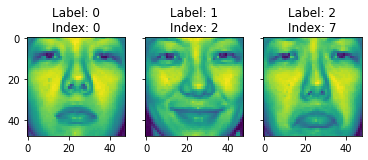

In [3]:
f, ax = plt.subplots(1, 3, sharey=True)
imgs = np.zeros([len(data.X_train), 48, 48])


def plot_img(X, ax, title, width=48, height=48):
    """Plot an image X with label y. The image will be reshaped to width*height"""
    img = X.reshape([width, height])
    ax.imshow(img, interpolation="nearest")
    ax.set_title(title)


def plot_catogories(X, y, ax, width=48, height=48):
    """Plot all the different catagories in an X."""
    found_catagories = set()
    for index, _X in enumerate(X):
        _y = y[index]
        if _y not in found_catagories:  # If the catagory is not in the set yet plot it and add it to the set
            plot_img(_X, ax[len(found_catagories)],
                     title=f"Label: {_y}\nIndex: {index}")
            found_catagories.add(_y)


plot_catogories(data.X_train, data.y_train, ax)

2. (5 points) Combine the target labels together in one array. Display your target class in a histogram. Is the dataset balanced?
    Marks breakdown:
    * 1 points for combining the target labels.
    * 3 points for display the histogram of the target classes with axis labelled and title included. 
    * 1 points for whether the dataset is balanced.

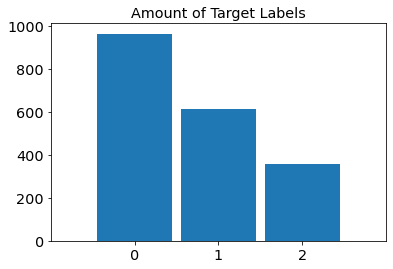

The dataset is not balanced at all. There are almost double the targets with label 0 vs targets with label 1. Likewise there are almost double the targets with label 1 vs label 2


In [4]:
labels = np.array(y_train, dtype=str)
np.append(labels, y_test)
np.append(labels, y_valid)

plt.hist(labels, bins=np.arange(5)-0.5, rwidth=0.9)
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
plt.xlim([-1, 3])
plt.title("Amount of Target Labels", fontsize="x-large")
plt.show()

print("The dataset is not balanced at all. There are almost double the targets with label 0 vs targets with label 1.",
      "Likewise there are almost double the targets with label 1 vs label 2")


### 1.3 Classification Tasks
1. (7 points) Train a k-nearest neighbour classifier (k = 1) with uniform weights. This classifier will be your baseline classifier. Marks breakdown:
    * 3 points for training and evaluating the accuracy of the KNN (with k = 1).
    * 2 points for displaying two mis-classified images for each class.
    * 1 points for providing other metrics (besdies accuracy) to evaluate this classifier.

Train score = 1.0
Test score = 0.7444933920704846
High train score and low test score indicates overfitting.
Precision: [0.736 0.891 0.5  ]

Recal:     [0.869 0.766 0.341]

fscore:    [0.797 0.824 0.406]

Support:   [122.  64.  41.]

The model took 0.0009996891021728516 seconds to run


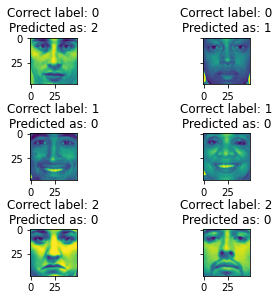

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier


t0 = time.time()

KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(data.X_train, data.y_train)

t1 = time.time()
total_time = t1 - t0

train_score = KNN.score(data.X_train, data.y_train)
test_score = KNN.score(data.X_test, data.y_test)

print(f"Train score = {train_score}\nTest score = {test_score}")
print("High train score and low test score indicates overfitting.")

y_pred = KNN.predict(data.X_valid)


def plot_wrong_image_predictions_per_catagory(X, y, y_pred, plots_per_label: int, width=48, height=48):
    differences = y == y_pred
    unique_labels = set(y)
    current_plot_index = 0

    f, ax = plt.subplots(len(unique_labels), plots_per_label, sharey=True)

    row = 0
    col = 0

    for target_label in unique_labels:

        for index, match in enumerate(differences):
            if not match and y[index] == target_label:
                img = X[index].reshape(width, height)
                ax[row][col].imshow(img)
                ax[row][col].set_title(
                    f"Correct label: {y[index]}\nPredicted as: {y_pred[index]}")
                current_plot_index += 1
                if col > plots_per_label - 2:
                    break
                col += 1
        row += 1
        col = 0

    f.tight_layout(pad=0.1)
    f.show()


plot_wrong_image_predictions_per_catagory(X_valid, y_valid, y_pred, 2)

def calcualte_precision_recall_fscore_support(model, data):
    model_predictions = model.predict(data.X_test)
    return np.round(precision_recall_fscore_support(data.y_test, model_predictions), 3)

# Other evaluators:

presision, recall, fscore, support = calcualte_precision_recall_fscore_support(KNN, data)

print(f"Precision: {presision}\n")
print(f"Recal:     {recall}\n")
print(f"fscore:    {fscore}\n")
print(f"Support:   {support}\n")
print(f"The model took {total_time} seconds to run")

2. (3 points) Find the best hyperparameters (number of neighbours) for the knn classifier.


1..3..5..7..9..11..13..15..17..19..21..23..25..27..29..31..33..35..37..39..41..43..45..47..49..51..53..55..57..59..61..63..65..67..69..71..73..75..77..79..81..83..85..
K 1 till 87 where checked with steps of 2
The best K was K=9
This K gave test score 0.75
Train score: 0.76


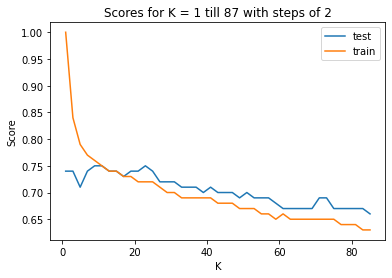

In [6]:
from collections import namedtuple


Result = namedtuple("Result", "k, train test")

results = []

highest_k_to_be_checked = int(len(data.X_train)**0.5*2)  # double of the sqaure of k
steps = 2

for k in range(1, highest_k_to_be_checked, steps):
    print(k, end='')
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(data.X_train, y_train)
    print(".", end='')
    train_score = KNN.score(data.X_train, data.y_train)
    test_score = KNN.score(data.X_test, data.y_test)
    print('.', end='')
    results.append(Result(k, round(train_score, 2), round(test_score, 2)))


# Find highest K
highest = results[0]
for result in results:
    if result.test > highest.test:
        highest = result
        
print("")
print(f"K 1 till {highest_k_to_be_checked} where checked with steps of {steps}\nThe best K was K={highest.k}")
print(f"This K gave test score {highest.test}\nTrain score: {highest.train}")


baseline_train = highest.train
baseline_test = highest.test

plt.figure()
plt.plot([result.k for result in results], [result.test for result in results], label="test")
plt.plot([result.k for result in results], [ result.train for result in results], label="train")

plt.legend()
plt.title(f"Scores for K = 1 till {highest_k_to_be_checked} with steps of {steps}")
plt.xlabel("K")
plt.ylabel("Score")
plt.show()

3. (45 points) Create and train classifiers and apply preprocessing methods to beat the baseline classifier. You can compare many machine learning approaches including supervised learning methods (k-nearest neighbours, SVMs, kernel SVMs, etc ) and dimensionality reduction (PCA, etc.
.). Your solution does not have to be limited to simply applying machine learning models, as well. Marks breakdown:
    * 15 points for comparing at least 4 other (low-level) machine learning algorithms, searching for best hyperparameters and beating the baseline classifier. Choose one or two hyperparameters (if there are any) to search for. (2 points per algorithm, 1 point for finding the best hyperparameters (if any) for each algorithm, 1 point for beating the baseline classifier and 2 points for clean well structured code.)
    * 5 points for training and evaluating the models with Random Forests or Gradient Boosting.
    * 5 points for training and evaluating with a heterogeneous ensemble learner such as Voting.
    * 5 points for evaluating all classifiers with additional metrics (beyond accuracy), comparing the computational times of each classifier and describing the results in a table in your report.
    * 5 points for two dimensional reduction or feature selection techniques. You should justify the number of components selected.
    * 5 points for balancing the dataset with an appropriate data balancing technique.
    * 5 points for implementing additional solutions such as streamlining your code with functions or pipelines.

These are the hyperparameters I am going to try:
### Decision trees
- criterion 
- splitter 
- max_depth
- max_features

### Kernel Support Vector Machines
- c
- different kernels  

### Naive Bayes
- None

### Linear Support Vector Machines
- c

### Imports: 

In [15]:
from copy import deepcopy
from sklearn.svm import SVC
from itertools import product
from sklearn.base import clone
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier

### Balance the data:

In [8]:
# Balancing the training data 

Balancer = RandomOverSampler(random_state=random_state)

X_train_ros, y_train_ros = Balancer.fit_resample(data.X_train, data.y_train)
print(f"Oversampled {len(X_train_ros) - len(data.X_train)} data points from the training set to balance the data.")

Oversampled 959 data points from the training set to balance the data.


In [9]:
# Replace old training data with balanced data
data.X_train = X_train_ros
data.y_train = y_train_ros

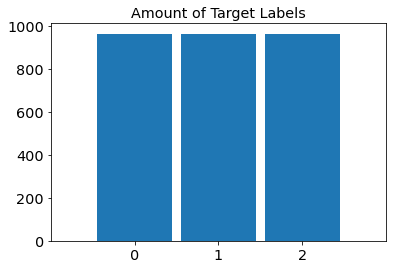

In [10]:
# Plot the current data
labels = np.array(data.y_train, dtype=str)

plt.hist(labels, bins=np.arange(5)-0.5, rwidth=0.9)
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
plt.xlim([-1, 3])
plt.title("Amount of Target Labels", fontsize="x-large")
plt.show()

### Reduce dimensionality:

In [11]:
pca = PCA(n_components=0.95) # n_componets that explain atleast 95 % of the variance
pca_train_data = pca.fit_transform(data.X_train, data.y_train)  
pca_test_data = pca.transform(data.X_test)
pca_valid_data = pca.transform(data.X_valid)

pca_components_kept = len(pca_train_data[0])

print(f"Kept {pca_components_kept} componets with pca. This explains 95 % of the variance.")

nmf = NMF(n_components=pca_components_kept) # Keep the same amount of componets as PCA
nmf_train_data = nmf.fit_transform(data.X_train, data.y_train) 
nmf_test_data = nmf.transform(data.X_test) 
nmf_valid_data = nmf.transform(data.X_valid) 

Kept 74 componets with pca. This explains 95 % of the variance.


In [12]:
pca_data = Data(pca_train_data, pca_test_data, data.y_train,data.y_test, pca_valid_data, data.y_valid)
nmf_data = Data(nmf_train_data, nmf_test_data, data.y_train, data.y_test, nmf_valid_data, data.y_valid)

def compare_dimension_performance(Model, data: Data, reduced_data: Data):
    '''Compare dimsion reduced data with non reduced data on a model'''
    model = Model().fit(data.X_train, data.y_train)
    non_reduced_score = model.score(data.X_test, data.y_test)
    model_reduced = Model().fit(reduced_data.X_train, reduced_data.y_train)
    reduced_score = model_reduced.score(reduced_data.X_test, reduced_data.y_test)
    return non_reduced_score, reduced_score

non_pca_better = 0
non_nmf_better = 0
pca_better = 0
nmf_better = 0

models_to_try = [SVC, LinearSVC, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB]

for Model in models_to_try:
    non_pca_score, pca_score = compare_dimension_performance(Model, data, pca_data)
    if pca_score > non_pca_score:
        pca_better += 1
    else:
        non_pca_better += 1

    non_nmf_score, nmf_score = compare_dimension_performance(Model, data, nmf_data)
    if nmf_score > non_nmf_score:
        nmf_better += 1
    else:
        non_nmf_better += 1

In [13]:
# Parse results

# Find out if nmf did better then non nmf
print(f"Using pca dimension reduction gave better results with {pca_better}/{len(models_to_try)}.", end=' ')
if pca_better > non_pca_better:
    print(f"Using pca improved the results for most of the models.")
    is_pca_better = True
else:
    print("Using nmf improved the results for most of the models.")
    is_pca_better = False

# Find out if pca did better then non pca
print(f"Using nmf dimension reduction gave better results with {nmf_better}/{len(models_to_try)}.", end=' ')
if nmf_better > non_nmf_better:
    print("Using nmf improved the results for most of the models.")
    is_nmf_better = True
else:
    print("Using nmf did NOT improve the results for most of the models.")
    is_nmf_better = False


# Final comparison
if is_pca_better and is_nmf_better:
    if nmf_better > pca_better:
        print("NMF dimension reduction gave the best results.")
        best_data = nmf_data
    else:
        print("PCA dimension reduction gave the best results.")
        best_data = pca_data
elif is_pca_better:
    print("PCA dimension reduction gave the best results.")
    best_data = pca_data
elif is_mnf_better:
    print("NMF dimension reduction gave the best results.")
    best_data = pca_data
else:
    print("Dimension reduction techniques failed to improve results.")
    best_data = data

Using pca dimension reduction gave better results with 3/5. Using pca improved the results for most of the models.
Using nmf dimension reduction gave better results with 2/5. Using nmf did NOT improve the results for most of the models.
PCA dimension reduction gave the best results.


In [16]:
# Replace data with the best dimension reduction technique
data = best_data

### Helper functions and classes:

In [17]:
@dataclass
class Hyperparameter():
    """Represents a hyper parameter and what variables to try"""
    name: str
    values_to_try: list

    def as_dict(self):
        return {self.name: self.values_to_try}


def HyperparameterRange(name, start, end, step):
    """This function makes a Hyperparameter object with a range of values to try"""
    return Hyperparameter(name, range(start, end, step))


@dataclass
class BestHyperParameters:
    """Represents the best hyper parameter for a model and the scores it got with them"""
    best_parameters: dict
    train_score: float = 0.0
    test_score: float = 0.0
    valid_score: float = None
    total_time: int = None
    
    presision: list = None
    recall: list = None
    fscore: list = None
    support: list = None

    model = None
    
    def __repr__(self):
        model_name = self.model.__class__.__name__
        s = f"Best hyperparameters for the {model_name} model are:\n{self.best_parameters}\n"
        s += f"Train score: {self.train_score}, Test score {self.test_score}, Validation score {self.valid_score}\n"
        s += f"Precision:   {self.presision}\n"
        s += f"Recal:       {self.recall}\n"
        s += f"fscore:      {self.fscore}\n"
        s += f"Support:     {self.support}\n"
        s += f"The model took {self.total_time} seconds to run\n"
        return s

    def did_it_beat_baseline(self, baseline, verbose=True):
        '''True if the models test score is above the given baseline. Will also print this info if verbose
            Uses validation score if it is available otherwise uses test score
        '''
        # Pick valid score if available otherwise test score
        model_name = self.model.__class__.__name__
        
        if self.valid_score is not None:
            my_score = self.valid_score
            my_score_type = "Validaton"
        else:
            my_score = self.test_score
            my_score_type = "Test"
        
        if my_score > baseline:
            if verbose:
                print(f"The {model_name} model beat the baseline scores!")
                print(f"{my_score_type} score: {my_score} >  Baseline score: {baseline}!")
            return True
        else:
            if verbose:
                print(f"The {model_name} model did NOT beat the baseline!")
                print(f"{my_score_type} score: {my_score} < Baseline score: {baseline}.")
            return False


def HyperIter(*args):
    """An iterator that will retun all possible combinations of Hyperparameter to try"""
    values_to_try = [arg.values_to_try for arg in args if isinstance(arg, Hyperparameter)]
    kwarg = {}
    for values in product(*values_to_try):
        for index, value in enumerate(values):
            name = args[index].name
            kwarg[name] = value
        yield kwarg


def find_best_hyperparameters(Model, data: Data, *args, **kwargs) -> BestHyperParameters:
    """A function that finds the best hyperparameters for a model"""
    best = BestHyperParameters({})
    
    # For loop with all combination of given hyperparameters
    for parameters in HyperIter(*args):
        # print(parameters) # uncomment print to show parameter that is tried
        # Start timer
        t0 = time.time()
        
        # Make & fit the model
        model = Model(**parameters)
        model.fit(data.X_train, data.y_train)

        # End timer
        t1 = time.time()
        total_time = round(t1 - t0, 6)

        # Get train & test rounded
        train_score = round(model.score(data.X_train, data.y_train), 2)
        test_score = round(model.score(data.X_test, data.y_test), 2)
        
        # Check if the model beat the best model so far
        if best.test_score < test_score:
            # print(f"New best, {best.test_score} < {test_score} with {parameters}") # uncomment for new best info
            best.test_score = test_score
            best.train_score = train_score
            best.best_parameters = deepcopy(parameters)
            best.model =  clone(model).fit(data.X_train, data.y_train) # Clone and refit the model
            best.total_time = total_time
    
    # Calculate validation score with validation data for best model 
    best.valid_score = round(best.model.score(data.X_valid, data.y_valid), 2)
    
    # Calculate precision recall fscore support of the best model
    best.presision, best.recall, best.fscore, best.support = calcualte_precision_recall_fscore_support(best.model, data)
    return best

# Define the hyperparameters 
C = Hyperparameter("C", [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000])
gamma = Hyperparameter("gamma", ["scale", 0.001, 0.01, 0.1, 1, 10, 100])
kernels = Hyperparameter("kernel", ['poly', 'rbf', 'sigmoid'])

criterion = Hyperparameter("criterion", ["entropy", "gini"])
splitter = Hyperparameter("splitter", ["best", "random"])
max_depth = Hyperparameter("max_depth", [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16])
max_features = Hyperparameter("max_features", [1, 2, 3, 4, 5, "auto", "sqrt", "log2"])
ccp_alpha = Hyperparameter("ccp_alpha", [0.0, 0.01, 0.1, 0.2])

criterionBoosting = Hyperparameter("criterion", ["friedman_mse", "mse"])
n_estimators = Hyperparameter("n_estimators", [200]) 

random_state_parameter = Hyperparameter("random_state", [random_state])

### Running the models:

In [18]:
# Running the models
# Uncomment the prints in the find_best_hyperparameters function to see progress

print("Starting... (this one will take a while)")
best_tree = find_best_hyperparameters(DecisionTreeClassifier, data, criterion, splitter, max_depth, max_features, ccp_alpha, random_state_parameter)
print(best_tree)
     
best_K_SVC = find_best_hyperparameters(SVC, data, C, kernels, random_state_parameter)
print(best_K_SVC)

best_L_SVC = find_best_hyperparameters(LinearSVC, data, C, random_state_parameter) 
print(best_L_SVC )

best_NB = find_best_hyperparameters(GaussianNB, data)
print(best_NB)

best_Random_Forest = find_best_hyperparameters(RandomForestClassifier, data, n_estimators, criterion, random_state_parameter)
print(best_Random_Forest)

best_Gradient_boosting = find_best_hyperparameters(GradientBoostingClassifier, data, n_estimators, criterionBoosting, random_state_parameter) 
print(best_Gradient_boosting)

print("\nDone running the models!")

Starting... (this one will take a while)
Best hyperparameters for the DecisionTreeClassifier model are:
{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'max_features': 'auto', 'ccp_alpha': 0.0, 'random_state': 137}
Train score: 0.86, Test score 0.71, Validation score 0.63
Precision:   [0.756 0.71  0.553]
Recal:       [0.787 0.688 0.512]
fscore:      [0.771 0.698 0.532]
Support:     [122.  64.  41.]
The model took 0.077007 seconds to run

Best hyperparameters for the SVC model are:
{'C': 100, 'kernel': 'rbf', 'random_state': 137}
Train score: 1.0, Test score 0.85, Validation score 0.9
Precision:   [0.855 0.966 0.676]
Recal:       [0.918 0.891 0.61 ]
fscore:      [0.885 0.927 0.641]
Support:     [122.  64.  41.]
The model took 0.723 seconds to run

Best hyperparameters for the LinearSVC model are:
{'C': 0.0001, 'random_state': 137}
Train score: 0.87, Test score 0.83, Validation score 0.84
Precision:   [0.892 0.924 0.56 ]
Recal:       [0.811 0.953 0.683]
fscore:      [0.85  0

### Did any model beat the the baseline? 

In [34]:
print(f"The baseline scores were test: {baseline_train} and train: {baseline_test}\n")

best_tree.did_it_beat_baseline(baseline_test)
best_K_SVC.did_it_beat_baseline(baseline_test)
best_L_SVC.did_it_beat_baseline(baseline_test)
best_NB.did_it_beat_baseline(baseline_test) 

best_Gradient_boosting.did_it_beat_baseline(baseline_test)
best_Random_Forest.did_it_beat_baseline(baseline_test)

The baseline scores were test: 0.76 and train: 0.75

The DecisionTreeClassifier model did NOT beat the baseline!
Validaton score: 0.63 < Baseline score: 0.75.
The SVC model beat the baseline scores!
Validaton score: 0.9 >  Baseline score: 0.75!
The LinearSVC model beat the baseline scores!
Validaton score: 0.84 >  Baseline score: 0.75!
The GaussianNB model did NOT beat the baseline!
Validaton score: 0.65 < Baseline score: 0.75.
The GradientBoostingClassifier model beat the baseline scores!
Validaton score: 0.88 >  Baseline score: 0.75!
The RandomForestClassifier model beat the baseline scores!
Validaton score: 0.81 >  Baseline score: 0.75!


True

In [33]:
# Run the voting classifier
estimators = [("linearSVC", best_L_SVC.model), ("SVC", best_L_SVC.model), ("DecisionTree", best_tree.model),("NB", best_NB.model), ("RandomForest", best_Random_Forest.model), ("GradientBoosting", best_Gradient_boosting.model)]

t0 = time.time()

voting_model = VotingClassifier(estimators, voting='hard')
voting_model.fit(data.X_train, data.y_train)

t1 = time.time()
total_time = t1 - t0

train_score = round(voting_model.score(data.X_train, data.y_train), 2)
test_score = round(voting_model.score(data.X_test, data.y_test), 2)
validation_score = round(voting_model.score(data.X_valid, data.y_valid), 2)

print("Voting scores:")
print("Train score: ", train_score)
print("Test score: ", test_score)
print("Valid score: ", test_score)

calcualte_precision_recall_fscore_support(voting_model, data)

r =  f"Precision:    {presision}\n"
r += f"Recal:       {recall}\n"
r += f"fscore:      {fscore}\n"
r += f"Support:     {support}\n"
r += f"The model took {total_time} seconds to run\n"
print(r)

Voting scores:
Train score:  0.96
Test score:  0.84
Valid score:  0.84
Precision:    [0.736 0.891 0.5  ]
Recal:       [0.869 0.766 0.341]
fscore:      [0.797 0.824 0.406]
Support:     [122.  64.  41.]
The model took 73.50644111633301 seconds to run



# 2  Regression to estimate the width of a grey kangaroo’s nose


You will create code to perform regression on a dataset from Australian Journal of Zoology, Vol. 28, p607-613 with Python libraries.

### 2.1 Dataset
The dataset consists of two continuous variables; the nasal length and nasal width (in mm) for male grey kangaroos.

In [35]:
# Load the data
csv_data = np.genfromtxt(data_path + '\kanga.csv', delimiter=',', skip_header=True)

### 2.2 Exploratory Data Analysis Tasks
1. (3 points) Present a scatterplot displaying the relationship between these two variables. Label the x axis as nasal length (mm) and y axis as nasal width (mm). Add a title to the scatterplot.

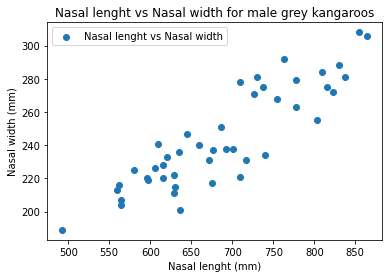

In [36]:
# Get x and y collums the arrays
X = csv_data[:, 0].reshape(-1, 1)  
y = csv_data[:,1]

# Make the scatter plot
plt.scatter(X, y, label=r"Nasal lenght vs Nasal width")
plt.xlabel("Nasal lenght (mm)")
plt.ylabel("Nasal width (mm)")
plt.title("Nasal lenght vs Nasal width for male grey kangaroos")
plt.legend()
plt.show()

### 2.3 Regression Tasks
1. (2 points) Split your dataset into 90% training and 10% testing.

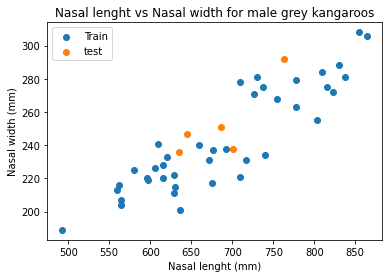

In [37]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=random_state)

data2 = Data(X_train2, X_test2, y_train2, y_test2)

plt.figure()
plt.scatter(X_train2, y_train2, label="Train")
plt.scatter(X_test2, y_test2, label="test")
plt.legend()
plt.xlabel("Nasal lenght (mm)")
plt.ylabel("Nasal width (mm)")
plt.title("Nasal lenght vs Nasal width for male grey kangaroos")

plt.show()

2. (5 points) Linear fitting: Fit a linear regression model to the data. Evaluate how successful the fit is by computing the R2 score.

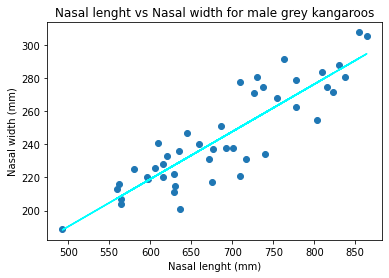

R2 is 0.777 

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


LR = LinearRegression()
LR.fit(X, y)

LR_y_prediction = LR.predict(X)

plt.figure()
plt.scatter(X, y)
plt.plot(X, LR_y_prediction, color="cyan")

plt.xlabel("Nasal lenght (mm)")
plt.ylabel("Nasal width (mm)")
plt.title("Nasal lenght vs Nasal width for male grey kangaroos")

plt.show()

# What is the R2 score?
r2 = round(r2_score(y, LR_y_prediction), 3)
print(f"R2 is {r2}", end=" ")

3. (3 points) Fit the linear regression model with cross validation and evaluate the mean R2 score.

In [39]:
r2_scores = cross_val_score(LR, X, y, scoring='r2')
mean_r2_linear_regression = round(np.mean(r2_scores), 3)
print(f"Cross validated R2 scores are {r2_scores}")
print(f"Mean R2 score is {mean_r2_linear_regression}")

print("\nI got 0.234, so not great. It is caused by one of the cross validated scores being -1.5.\nApperently one of the folds gives bad performance.")

Cross validated R2 scores are [ 0.61765389  0.63501709  0.90178865 -1.48731674  0.50294111]
Mean R2 score is 0.234

I got 0.234, so not great. It is caused by one of the cross validated scores being -1.5.
Apperently one of the folds gives bad performance.


4. (10 points) Using Grid Search and Cross Validation, compare the performance of regression analysis with SVM regression, and Decision Tree regression using the R2 score as a metric. Display your solutions in a plot.

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


svr_grid_params = C.as_dict() | gamma.as_dict()
tree_grid_params = max_depth.as_dict() | max_features.as_dict() | ccp_alpha.as_dict()

svr_grid = GridSearchCV(SVR(), svr_grid_params, verbose=1, scoring="r2")
tree_grid = GridSearchCV(DecisionTreeRegressor(), tree_grid_params, verbose=1, scoring="r2")

svr_grid.fit(X_train2, y_train2)
tree_grid.fit(X_train2, y_train2)

svc_score = svr_grid.score(X_test2, y_test2)
tree_score = tree_grid.score(X_test2, y_test2)

print(f"SVR R2 score: {svc_score}")
print(f"Decision Tree R2 score: {tree_score}")



Fitting 5 folds for each of 56 candidates, totalling 280 fits
Fitting 5 folds for each of 544 candidates, totalling 2720 fits
SVR R2 score: 0.15147455600951465
Decision Tree R2 score: 0.21019495855022174


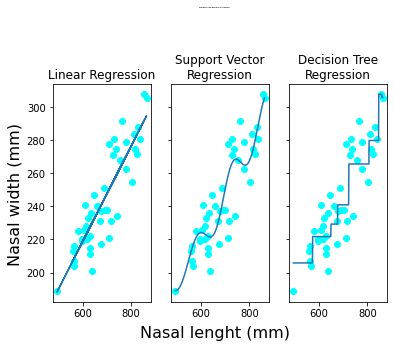

In [41]:
fig, ax = plt.subplots(1,3, sharey=True)
fig.suptitle('Nasal Lenght vs Nasal width for male grey kangaroos', fontsize=1, y=1.15, fontweight="bold")

fig.text(0.5, 0.00, 'Nasal lenght (mm)', ha='center', fontsize=16)
fig.text(0.02, 0.5, 'Nasal width (mm)', va='center', rotation='vertical', fontsize=16)

for plot in ax:
    plot.scatter(X, y, color="cyan")
    
ax[0].plot(X, LR_y_prediction, label="Linear Regression")
ax[0].set_title("Linear Regression")

# Make predictions for svr and tree
x_axis = np.arange(np.min(X), np.max(X)).reshape(-1, 1)
svr_y_predict = svr_grid.predict(x_axis)
tree_y_predict = tree_grid.predict(x_axis)

ax[1].plot(x_axis, svr_y_predict, label="Support Vector Regression")
ax[1].set_title("Support Vector\nRegression")

ax[2].plot(x_axis, tree_y_predict, label="Decision Tree Regression")
ax[2].set_title("Decision Tree\nRegression")

plt.show()

5. (2 points) Select the best performing regression model.

In [42]:
# Select the best performing regression model based of the R2 score
if svr_score > mean_r2_linear_regression and svr_score > tree_score:
     print("The Support Vector Regression model performed the best!")
elif tree_score > mean_r2_linear_regression and tree_score > svr_score:
     print("The Decision tree model performed the best!")
else:
     print("The Linear regression model performed the best!")

NameError: name 'svr_score' is not defined

### 2.4 Missing Data Imputation Task
1. (10 points) In your individual file XXXXXXX nose.csv (where XXXXXXX is your student ID), some variables are labelled with NaN. There variables are considered missing data. Perform a mean and a kNN (k = 3) data imputation. Compare the performance of a linear regression model with the two different data imputations.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer


# Load the data
filename = "2042647_nose.csv"
csv_nose_data = np.genfromtxt(data_path + "\\" + filename, delimiter=",", skip_header=True)

# Impute with KNN k = 3
imp_KNN = KNNImputer(n_neighbors=3).fit(csv_nose_data)
nose_imputed_KNN = imp_KNN.fit_transform(csv_nose_data)
X_nose_KNN = nose_imputed_KNN[:, 1].reshape(-1, 1)
y_nose_KNN = nose_imputed_KNN[:, 2]

LR_KNN = LinearRegression().fit(X_nose_KNN, y_nose_KNN)

# Impute with mean
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean').fit(csv_nose_data)
nose_imputed_mean = imp_mean.fit_transform(csv_nose_data)
X_nose_mean = nose_imputed_mean[:, 1].reshape(-1, 1)
y_nose_mean = nose_imputed_mean[:, 2]
LR_mean = LinearRegression().fit(X_nose_mean, y_nose_mean)

# Get R2 scores
r2_score_mean = round(r2_score(y_nose_mean, LR_KNN.predict(X_nose_mean)), 3)
r2_score_KNN = round(r2_score(y_nose_KNN, LR_mean.predict(X_nose_KNN)), 3)

# Print results
print(f"Mean imputation had an R2 score of {r2_score_mean}")
print(f"KNN imputation with k = 3 had an R2 score of {r2_score_KNN}\n")

if r2_score_mean > r2_score_KNN:
    print("Mean imputation gave the best performance")
else:
    print("KNN imputation with k = 3 gave the best performance")